### Load Data set

In [3]:
import os

In [4]:
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print("length: \n", len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
length: 
 420551


###  Convert all 420,551 lines of data into a Numpy array.

In [5]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plot of temperature (in degrees Celsius) over time

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

### More narrow plot of the first ten days of temperature data

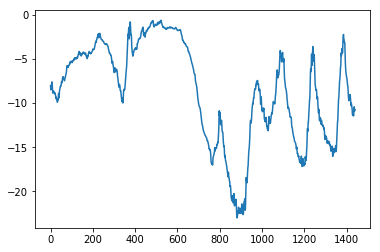

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

### Data Pre-processing

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Non-machine learning technique

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


### Basic Machine Learning approach

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 1.7535 - val_loss: 0.8196
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.6516 - val_loss: 0.5000
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3411 - val_loss: 0.3288
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2839 - val_loss: 0.3026
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2638 - val_loss: 0.3034
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2539 - val_loss: 0.3079
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2446 - val_loss: 0.3120
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2375 - val_loss: 0.3199
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2301 - val_loss: 0.3242
Epoch 10/20
500/500 [==============================] - 17s 35ms/step - loss: 0.225

### Loss curves for validation and training

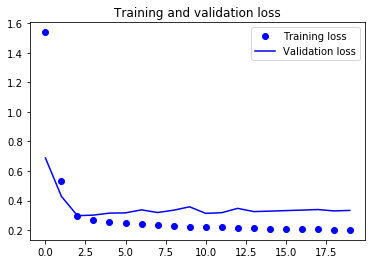

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### First recurrent baseline

In [14]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 126s 252ms/step - loss: 0.3027 - val_loss: 0.2773
Epoch 2/20
500/500 [==============================] - 122s 243ms/step - loss: 0.2839 - val_loss: 0.2699
Epoch 3/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2775 - val_loss: 0.2664
Epoch 4/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2708 - val_loss: 0.2651
Epoch 5/20
500/500 [==============================] - 123s 246ms/step - loss: 0.2666 - val_loss: 0.2655
Epoch 6/20
500/500 [==============================] - 121s 241ms/step - loss: 0.2609 - val_loss: 0.2707
Epoch 7/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2565 - val_loss: 0.2692
Epoch 8/20
500/500 [==============================] - 119s 238ms/step - loss: 0.2504 - val_loss: 0.2713
Epoch 9/20
500/500 [==============================] - 118s 237ms/step - loss: 0.2475 - val_loss: 0.2836
Epoch 10/20
500/500 [==============================] - 118s 236m

### Result

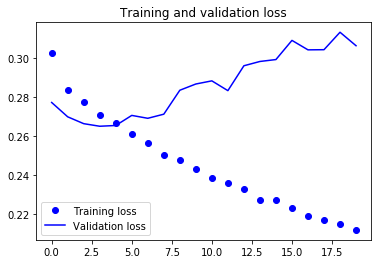

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Using dropout to prevent overfitting

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 140s 279ms/step - loss: 0.3315 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 140s 279ms/step - loss: 0.3129 - val_loss: 0.2713
Epoch 3/40
500/500 [==============================] - 139s 278ms/step - loss: 0.3070 - val_loss: 0.2694
Epoch 4/40
500/500 [==============================] - 139s 279ms/step - loss: 0.3039 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 140s 280ms/step - loss: 0.2976 - val_loss: 0.2702
Epoch 6/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2968 - val_loss: 0.2687
Epoch 7/40
500/500 [==============================] - 139s 279ms/step - loss: 0.2952 - val_loss: 0.2666
Epoch 8/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2935 - val_loss: 0.2657
Epoch 9/40
500/500 [==============================] -